# Plotting the toy model results

## 1. Necessary imports and configuration

In [1]:
import os
import random
import itertools
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from numpy.ma import masked_array
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

plt.rcParams.update({'font.size': 16, 'font.family': 'serif'})

In [3]:
mapper = {
    'memorization': 0,
    'grokking': 1,
    'comprehension': 2,
    'confusion': 3
}
inv_mapper = {v: k for k, v in mapper.items()}

def load_phases(save_dir: str, acc_thr: float = 0.9 - 1e-3):
    """
    Load experimental results with training phases
    :param save_dir: path to save training states
    :param acc_thr: phases accuracy threshold
    :return: table with phases for the grid of learning rate and weight decay
    """
    phases = {}
    grokking_diff = 10 ** 3

    for file in os.listdir(save_dir):
        if file == 'data.state':
            continue

        state = torch.load(os.path.join(save_dir, file))
        if acc_thr < 0.9 - 1e-3:
            """
            If the threshold is different from the experimental run, redetermine the phases
            """
            train_acc, test_acc = np.array(state['train_acc']), np.array(state['test_acc'])
            train_iter = None if np.all(train_acc < acc_thr) else 1 + np.argmax(train_acc >= acc_thr)
            test_iter = None if np.all(test_acc < acc_thr) else 1 + np.argmax(test_acc >= acc_thr)

            if train_iter is None:
                phase = 'confusion'
            elif test_iter is None:
                phase = 'memorization'
            else:
                if test_iter - train_iter < grokking_diff:
                    phase = 'comprehension'
                else:
                    phase = 'grokking'

            phases[(state['dec_lr'], state['dec_wd'])] = phase

        else:
            phases[(state['dec_lr'], state['dec_wd'])] = state['phase']

    lrs, wds = zip(*phases.keys())
    lrs = np.unique(lrs)
    lrs.sort()
    wds = np.unique(wds)
    wds.sort()
    data = np.zeros((len(lrs), len(wds)))

    for i, lr in enumerate(lrs):
        for j, wd in enumerate(wds):
            data[j, i] = mapper[phases.get((lr, wd), 'confusion')]

    data = pd.DataFrame(data=data, index=wds, columns=lrs)
    return data

## 2. Phase diagrams for different random seeds

In [4]:
cls_data, regr_data = {}, {}
data_seeds = [41, 42, 43]
model_seeds = [101, 102, 103]
seed_product = list(itertools.product(data_seeds, model_seeds))

for data_seed, model_seed in tqdm(seed_product):
    cls_data[(data_seed, model_seed)] = load_phases(
        f'experiments/cls_tanh_data{data_seed}_model{model_seed}'
    )

    regr_data[(data_seed, model_seed)] = load_phases(
        f'experiments/regr_tanh_data{data_seed}_model{model_seed}'
    )

  0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
def plot_diagram(ax: matplotlib.axes.Axes, data: pd.DataFrame, ticksize: int = 16, labelsize: int = 20,
                 legend: bool = True, x_label: bool = True, y_label: bool = True,
                 xtick_freq: int = 4, ytick_freq: int = 2):
    """
    Plot phase diagram
    :param ax: matplotlib axes object
    :param data: phases dataframe
    :param ticksize: font size for ticks
    :param labelsize: font size for labels
    :param legend: whether to plot legend
    :param x_label: whether to annotate x-axis
    :param y_label: whether to annotate y-axis
    :param xtick_freq: frequency of x-ticks
    :param ytick_freq: frequency of y-ticks
    """
    # Draw diagram
    cmap = matplotlib.colors.ListedColormap(['darkslateblue', 'gold', 'yellowgreen', 'black'])
    ax.imshow(np.array(data), cmap=cmap)

    # Annotate x-axis
    if x_label:
        xlabels = data.columns[::xtick_freq]
        xlabels = ['{:.2e}'.format(float(x)) for x in xlabels]
        ax.set_xticks(np.arange(len(data.columns))[::xtick_freq], labels=xlabels, rotation=-45, size=ticksize)
        ax.set_xlabel('learning rate', size=labelsize)
    else:
        ax.set_xticks([])

    # Annotate y-axis
    if y_label:
        ylabels = data.index[::ytick_freq]
        ylabels = ['{}'.format(int(x)) for x in ylabels]
        ax.set_yticks(np.arange(len(data.index))[::ytick_freq], labels=ylabels, rotation=0, size=ticksize)
        ax.set_ylabel('weight decay', size=labelsize)
    else:
        ax.set_yticks([])

    # Plot legend
    if legend:
        values = np.unique(data).astype(np.uint8)
        colors = [cmap(value) for value in values]
        patches = [mpatches.Patch(color=colors[i], label=f"{inv_mapper[i]}") for i in range(len(values))]
        ax.legend(handles=patches, borderaxespad=0.5, fontsize=labelsize, loc='upper center',
                  bbox_to_anchor=(0.5, -0.22), fancybox=True, shadow=True, ncol=2)

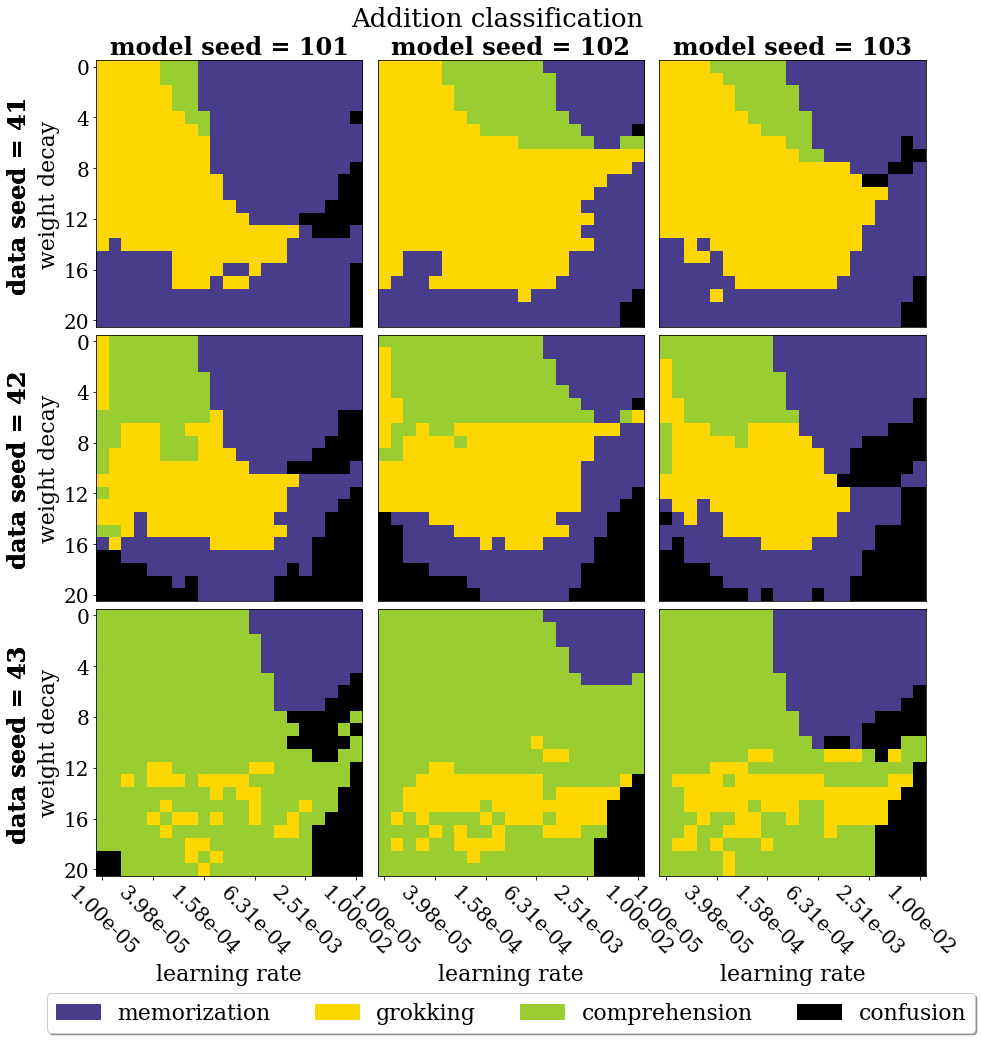

In [7]:
fig, axs = plt.subplots(len(data_seeds), len(model_seeds), figsize=(15, 15))

for i, data_seed in enumerate(data_seeds):
    for j, model_seed in enumerate(model_seeds):
        plot_diagram(
            axs[i, j], cls_data[(data_seed, model_seed)], legend=False,
            x_label=(i == len(data_seeds) - 1), y_label=(j == 0),
            ticksize=20, labelsize=22, ytick_freq=4
        )
        axs[0, j].set_title(f'model seed = {model_seed}', fontsize=24, fontweight='bold')
        axs[i, 0].text(-7.5, 17.5, f'data seed = {data_seed}', fontsize=24, rotation=90, fontweight='bold')

cmap = matplotlib.colors.ListedColormap(['darkslateblue', 'gold', 'yellowgreen', 'black'])
values = np.unique(cls_data[(41, 101)]).astype(np.uint8)
colors = [cmap(value) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{inv_mapper[i]}") for i in range(len(values))]
axs[2, 1].legend(handles=patches, borderaxespad=0.5, fontsize=22, loc='upper center',
                 bbox_to_anchor=(0.5, -0.4), fancybox=True, shadow=True, ncol=4)

plt.suptitle('Addition classification', fontsize=26, y=0.93)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

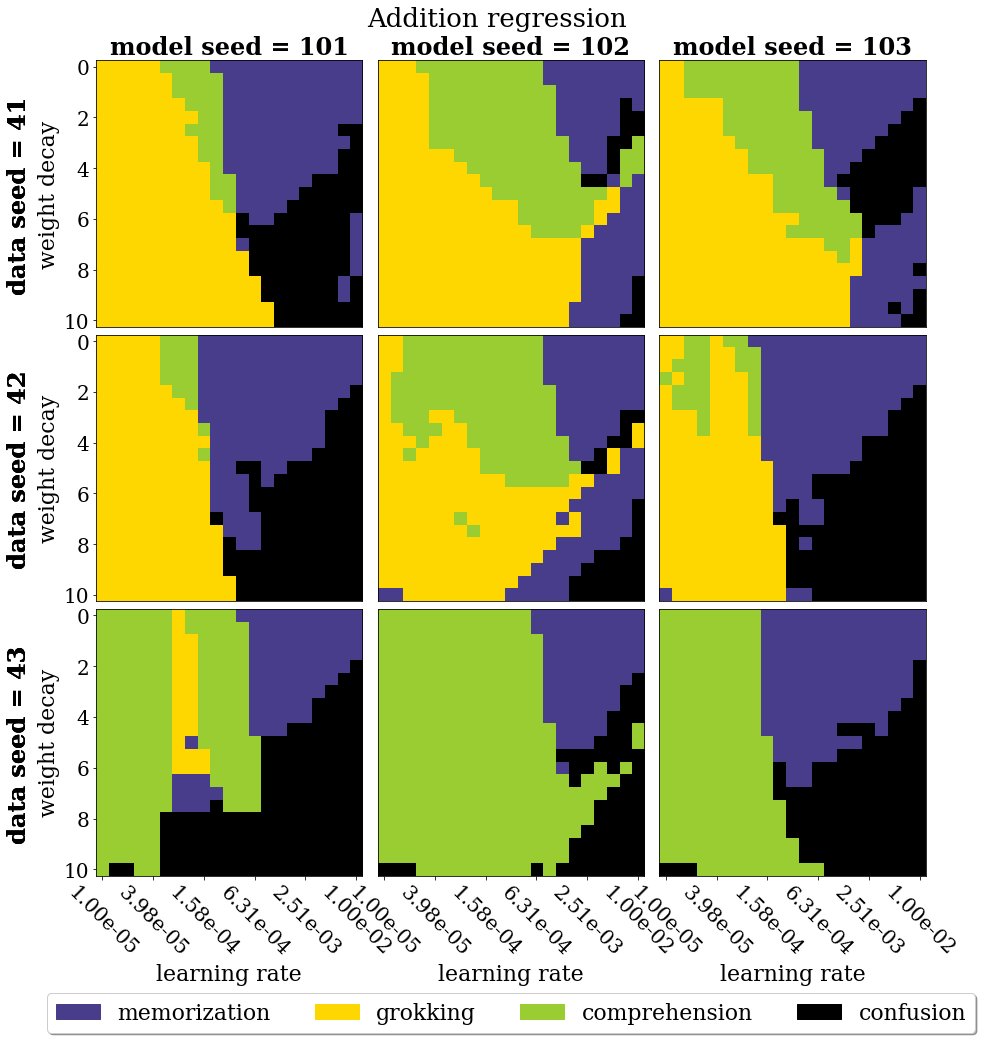

In [8]:
fig, axs = plt.subplots(len(data_seeds), len(model_seeds), figsize=(15, 15))

for i, data_seed in enumerate(data_seeds):
    for j, model_seed in enumerate(model_seeds):
        plot_diagram(
            axs[i, j], regr_data[(data_seed, model_seed)], legend=False,
            x_label=(i == len(data_seeds) - 1), y_label=(j == 0),
            ticksize=20, labelsize=22, ytick_freq=4
        )
        axs[0, j].set_title(f'model seed = {model_seed}', fontsize=24, fontweight='bold')
        axs[i, 0].text(-7.5, 17.5, f'data seed = {data_seed}', fontsize=24, rotation=90, fontweight='bold')

cmap = matplotlib.colors.ListedColormap(['darkslateblue', 'gold', 'yellowgreen', 'black'])
values = np.unique(regr_data[(41, 101)]).astype(np.uint8)
colors = [cmap(value) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{inv_mapper[i]}") for i in range(len(values))]
axs[2, 1].legend(handles=patches, borderaxespad=0.5, fontsize=22, loc='upper center',
                 bbox_to_anchor=(0.5, -0.4), fancybox=True, shadow=True, ncol=4)

plt.suptitle('Addition regression', fontsize=26, y=0.93)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

## 3. Phase diagrams for different activation functions

In [9]:
cls_data, regr_data = {}, {}
data_seed = 42
model_seed = 102
activations = ['relu', 'leaky_relu', 'tanh']

for activation in tqdm(activations):
    cls_data[activation] = load_phases(
        f'experiments/cls_{activation}_data{data_seed}_model{model_seed}'
    )

    regr_data[activation] = load_phases(
        f'experiments/regr_{activation}_data{data_seed}_model{model_seed}'
    )

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
act_names = {
    'relu': 'ReLU',
    'leaky_relu': 'LeakyReLU(0.1)',
    'tanh': 'Tanh'
}

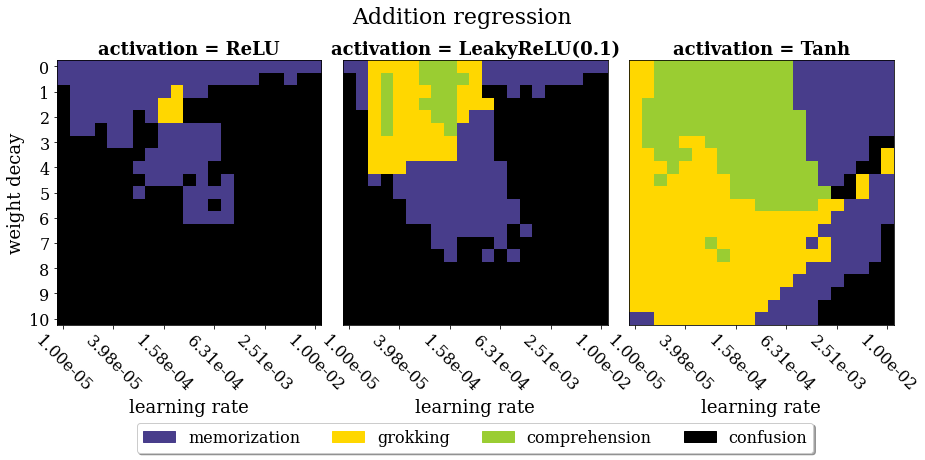

In [11]:
fig, axs = plt.subplots(1, len(activations), figsize=(15, 5))

for i, activation in enumerate(activations):
    plot_diagram(
        axs[i], regr_data[activation], legend=False,
        x_label=True, y_label=(i == 0),
        ticksize=16, labelsize=18
    )
    axs[i].set_title(f'activation = {act_names[activation]}', fontsize=18, fontweight='bold')

cmap = matplotlib.colors.ListedColormap(['darkslateblue', 'gold', 'yellowgreen', 'black'])
values = np.unique(regr_data['leaky_relu']).astype(np.uint8)
colors = [cmap(value) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{inv_mapper[i]}") for i in range(len(values))]
axs[1].legend(handles=patches, borderaxespad=0.5, fontsize=16, loc='upper center',
              bbox_to_anchor=(0.5, -0.34), fancybox=True, shadow=True, ncol=4)

plt.suptitle('Addition regression', fontsize=22, y=1.02)
plt.subplots_adjust(wspace=0.08, hspace=0.08)

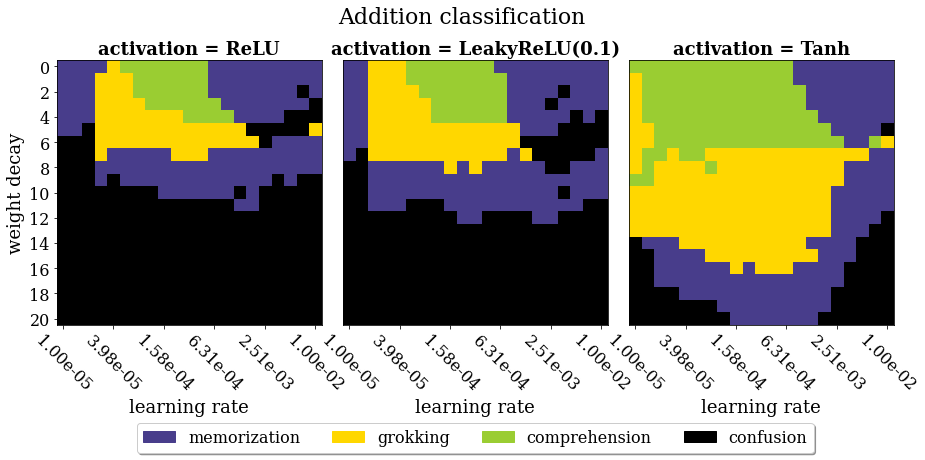

In [12]:
fig, axs = plt.subplots(1, len(activations), figsize=(15, 5))

for i, activation in enumerate(activations):
    plot_diagram(
        axs[i], cls_data[activation], legend=False,
        x_label=True, y_label=(i == 0),
        ticksize=16, labelsize=18
    )
    axs[i].set_title(f'activation = {act_names[activation]}', fontsize=18, fontweight='bold')

cmap = matplotlib.colors.ListedColormap(['darkslateblue', 'gold', 'yellowgreen', 'black'])
values = np.unique(cls_data['leaky_relu']).astype(np.uint8)
colors = [cmap(value) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{inv_mapper[i]}") for i in range(len(values))]
axs[1].legend(handles=patches, borderaxespad=0.5, fontsize=16, loc='upper center',
              bbox_to_anchor=(0.5, -0.34), fancybox=True, shadow=True, ncol=4)

plt.suptitle('Addition classification', fontsize=22, y=1.02)
plt.subplots_adjust(wspace=0.08, hspace=0.08)

# 4. Original phase diagrams from the paper

Text(0.5, 1.0, 'Addition regression')

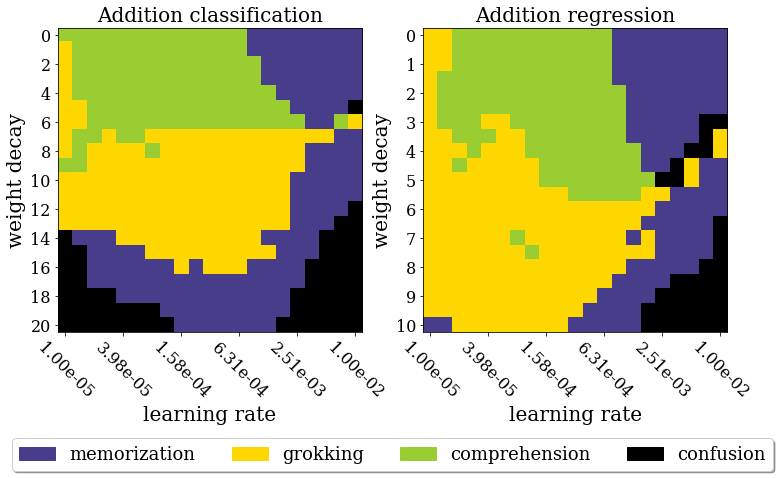

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_diagram(
    axs[0], cls_data['tanh'], legend=False,
    x_label=True, y_label=True, xtick_freq=4,
    ticksize=16, labelsize=20
)
axs[0].set_title('Addition classification', fontsize=20)

plot_diagram(
    axs[1], regr_data['tanh'], legend=False,
    x_label=True, y_label=True, xtick_freq=4,
    ticksize=16, labelsize=20
)

cmap = matplotlib.colors.ListedColormap(['darkslateblue', 'gold', 'yellowgreen', 'black'])
values = np.unique(cls_data['tanh']).astype(np.uint8)
colors = [cmap(value) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f"{inv_mapper[i]}") for i in range(len(values))]
axs[1].legend(handles=patches, borderaxespad=0.5, fontsize=18, loc='upper center',
              bbox_to_anchor=(-0.1, -0.32), fancybox=True, shadow=True, ncol=4)

axs[1].set_title('Addition regression', fontsize=20)


## 5. Embeddings optimization trajectories

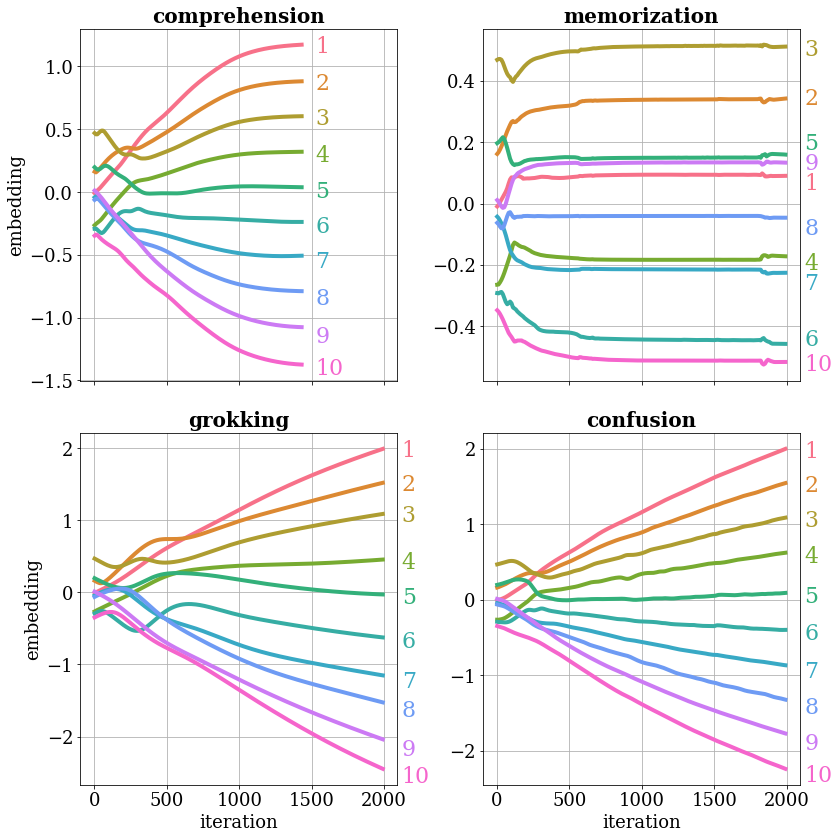

In [21]:
files = [
    'experiments/regr_tanh_data42_model102/lr=1.585e-04-wd=0.000e+00.state',
    'experiments/regr_tanh_data42_model102/lr=1.000e-02-wd=0.000e+00.state',
    'experiments/regr_tanh_data42_model102/lr=1.000e-05-wd=5.000e+00.state',
    'experiments/regr_tanh_data42_model102/lr=1.000e-02-wd=1.000e+01.state',
]

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True)
plt.rcParams.update({'font.size': 18})
colors = sns.color_palette("husl", 10)

for file, ax in zip(files, axs.flatten()):
    state = torch.load(file)
    embeds = state['embeds_history'].squeeze()[:200]
    phase = state['phase']

    for i in range(10):
        xs = [1] + (10 * np.arange(1, embeds.shape[0])).tolist()
        ys = embeds[:, i].numpy()
        ax.plot(xs, ys, label=i + 1, color=colors[i], linewidth=4)

        x_min, x_max = ax.get_xlim()
        dx = x_max - x_min
        y_min, y_max = ax.get_ylim()
        dy = y_max - y_min

        ey = 0
        if phase != 'memorization' and i + 1 == 10:
            ey = 0.06
        elif phase == 'memorization' and i + 1 == 5:
            ey = 0.06
        elif phase == 'memorization' and i + 1 == 1:
            ey = -0.04
        elif phase == 'memorization' and i + 1 == 6:
            ey = 0.05
        elif phase == 'memorization' and i + 1 == 9:
            ey = 0.03
        elif phase == 'memorization' and i + 1 == 10:
            ey = 0.03

        ax.text(xs[-1] + dx * 0.06, ys[-1] - dy * 0.05 + ey, s=str(i + 1), color=colors[i], fontsize=22)

    ax.grid()
    ax.set_title(f"{phase}", fontweight='bold', fontsize=20)

    if phase in ['grokking', 'confusion']:
        ax.set_xlabel('iteration')
    if phase in ['comprehension', 'grokking']:
        ax.set_ylabel('embedding')

plt.tight_layout()

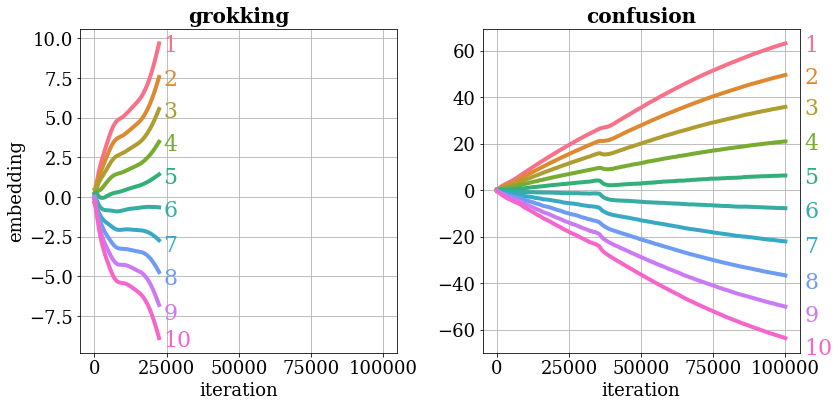

In [15]:
files = [
    'experiments/regr_tanh_data42_model102/lr=1.000e-05-wd=5.000e+00.state',
    'experiments/regr_tanh_data42_model102/lr=1.000e-02-wd=1.000e+01.state',
]

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
plt.rcParams.update({'font.size': 18})
colors = sns.color_palette("husl", 10)

for file, ax in zip(files, axs.flatten()):
    state = torch.load(file)
    embeds = state['embeds_history'].squeeze()
    phase = state['phase']

    for i in range(10):
        xs = [1] + (10 * np.arange(1, embeds.shape[0])).tolist()
        ys = embeds[:, i].numpy()
        ax.plot(xs, ys, label=i + 1, color=colors[i], linewidth=4)

        x_min, x_max = ax.get_xlim()
        dx = x_max - x_min
        y_min, y_max = ax.get_ylim()
        dy = y_max - y_min
        ey = 0
        if phase == 'grokking' and i + 1 == 10:
            ey = 0.5

        ax.text(xs[-1] + dx * 0.06, ys[-1] - dy * 0.05 + ey, s=str(i + 1), color=colors[i], fontsize=22)

    ax.grid()
    #ax.set_xscale('log')
    #ax.set_yscale('symlog')
    ax.set_title(f"{phase}", fontweight='bold', fontsize=20)

    if phase in ['grokking', 'confusion']:
        ax.set_xlabel('iteration')
    if phase in ['comprehension', 'grokking']:
        ax.set_ylabel('embedding')

plt.tight_layout()

## 6. Smooth phase diagrams

In [16]:
def load_smooth_phases(save_dir: str, acc_thr: float = 0.9 - 1e-3):
    """
    Load experimental results and smooth training phases
    :param save_dir: path to save training states
    :param acc_thr: phases accuracy threshold
    :return: (data, train, test)
        data: table with phases for the grid of learning rate and weight decay
        train: table with training convergence iterations
        test: table with validation convergence iterations
    """
    phases = {}
    train_iters, test_iters = {}, {}
    grokking_diff = 10 ** 3

    for file in os.listdir(save_dir):
        if file == 'data.state':
            continue

        state = torch.load(os.path.join(save_dir, file))
        if acc_thr < 0.9 - 1e-3:
            train_acc, test_acc = np.array(state['train_acc']), np.array(state['test_acc'])
            train_iter = None if np.all(train_acc < acc_thr) else 1 + np.argmax(train_acc >= acc_thr)
            test_iter = None if np.all(test_acc < acc_thr) else 1 + np.argmax(test_acc >= acc_thr)

            if train_iter is None:
                phase = 'confusion'
            elif test_iter is None:
                phase = 'memorization'
            else:
                if test_iter - train_iter < grokking_diff:
                    phase = 'comprehension'
                else:
                    phase = 'grokking'

            phases[(state['dec_lr'], state['dec_wd'])] = phase
            train_iters[(state['dec_lr'], state['dec_wd'])] = train_iter
            test_iters[(state['dec_lr'], state['dec_wd'])] = test_iter

        else:
            phases[(state['dec_lr'], state['dec_wd'])] = state['phase']
            train_iters[(state['dec_lr'], state['dec_wd'])] = state['train_iter']
            test_iters[(state['dec_lr'], state['dec_wd'])] = state['test_iter']

    lrs, wds = zip(*phases.keys())
    lrs = np.unique(lrs)
    lrs.sort()
    wds = np.unique(wds)
    wds.sort()
    data = np.zeros((len(lrs), len(wds)))
    train = np.zeros((len(lrs), len(wds)))
    test = np.zeros((len(lrs), len(wds)))

    for i, lr in enumerate(lrs):
        for j, wd in enumerate(wds):
            data[j, i] = mapper[phases.get((lr, wd), 'confusion')]
            train[j, i] = train_iters.get((lr, wd), None)
            test[j, i] = test_iters.get((lr, wd), None)

    data = pd.DataFrame(data=data, index=wds, columns=lrs)
    train = pd.DataFrame(data=train, index=wds, columns=lrs)
    test = pd.DataFrame(data=test, index=wds, columns=lrs)
    return data, train, test

In [17]:
cls_long_data, cls_long_train, cls_long_test = load_smooth_phases(
    'experiments/cls_tanh_data42_model102_max_iters300000/'
)
regr_long_data, regr_long_train, regr_long_test = load_smooth_phases(
    'experiments/regr_tanh_data42_model102_max_iters300000/'
)

In [18]:
def plot_smooth_diagram(ax: matplotlib.axes.Axes, fig: matplotlib.figure.Figure,
                        data: pd.DataFrame, train: pd.DataFrame, test: pd.DataFrame,
                        x_label: bool = True, y_label: bool = True,
                        xtick_freq: int = 4, ytick_freq: int = 2, thr_pos: float = 0.5):
    """
    Plot smooth phase diagram
    :param ax: matplotlib axes object
    :param fig: matplotlib figure object
    :param data: phases dataframe
    :param train: train iterations dataframe
    :param test: validation iterations dataframe
    :param x_label: whether to annotate x-axis
    :param y_label: whether to annotate y-axis
    :param xtick_freq: frequency of x-ticks
    :param ytick_freq: frequency of y-ticks
    :param thr_pos: position of grokking threshold in colorbar
    """
    # Create smooth diagrams
    minval, maxval = 0, 5 + 1.5 * np.log10(3)
    data_np = np.array(data)
    result = np.copy(data_np)
    result = (result + 1) % 4
    tmp = np.log10(np.array(train))
    tmp = 1 - (tmp - minval) / (maxval - minval)
    result = np.where(data_np == 0, tmp, result)

    tmp = np.log10(1 + np.maximum(0, np.array(test - train)))
    tmp = 3 - (tmp - minval) / (maxval - minval)
    result = np.where((data_np == 1) | (data_np == 2), tmp, result)

    # Create colormaps
    blue = matplotlib.colors.to_rgb('darkslateblue')
    black = matplotlib.colors.to_rgb('black')
    blueblack = tuple(0.25 * a + 0.75 * b for a, b in zip(blue, black))

    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cmap1", [blueblack, 'darkslateblue']
    )
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap2", ['gold', 'green']
    )

    # Annotate x-axis
    if x_label:
        xlabels = data.columns[::xtick_freq]
        xlabels = ['{:.2e}'.format(float(x)) for x in xlabels]
        ax.set_xticks(np.arange(len(data.columns))[::xtick_freq], labels=xlabels, rotation=-45, size=16)
        ax.set_xlabel('learning rate', size=20)
    else:
        ax.set_xticks([])

    # Annotate y-axis
    if y_label:
        ylabels = data.index[::ytick_freq]
        ylabels = ['{}'.format(int(x)) for x in ylabels]
        ax.set_yticks(np.arange(len(data.index))[::ytick_freq], labels=ylabels, rotation=0, size=16)
        ax.set_ylabel('weight decay', size=20)
    else:
        ax.set_yticks([])

    # Draw diagrams
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    res1 = masked_array(result, result > 1)
    cm1 = ax.imshow(res1, cmap=cmap1, norm=norm)

    res2 = masked_array(result - 2, result <= 1)
    cm2 = ax.imshow(res2, cmap=cmap2, norm=norm)

    # Annotate colorbar
    labels1 = np.append(np.arange(0.5, 5.1, 0.5), 5 + np.log10(3))
    ticks1 = 1 - (labels1 - minval) / (maxval - minval)

    labels2 = np.arange(0.5, 5.1, 0.5)
    ticks2 = 1 - (labels2 - minval) / (maxval - minval)

    cbar1 = fig.colorbar(cm1, shrink=0.9, pad=0.1, ticks=ticks1)
    cbar2 = fig.colorbar(cm2, shrink=0.9, pad=0.2, ticks=ticks2)

    cbar2.ax.plot([0, 1], [1 - (3 - minval) / (maxval - minval)] * 2, 'r')
    cbar2.ax.text(-2.5, thr_pos, 'grokking\nthreshold', ha='center', va='center', fontsize=14)

    cbar1.ax.set_title('train\nconv iter', fontsize=16)
    cbar1.ax.text(-2, -0.15, 'memorization\n& confusion', fontsize=14)
    cbar1.ax.set_yticklabels(['$10^{' + f'{label:.1f}' + '}$' for label in labels1[:-1]] + ['>$3 \cdot 10^{5.0}$'],
                             fontsize=16)
    cbar2.ax.set_title('valid conv iter — \ntrain conv iter', fontsize=16)
    cbar2.ax.text(-2.8, -0.15, 'comprehension\n& grokking', fontsize=14)
    cbar2.ax.set_yticklabels(['$10^{' + f'{label:.1f}' + '}$' for label in labels2])

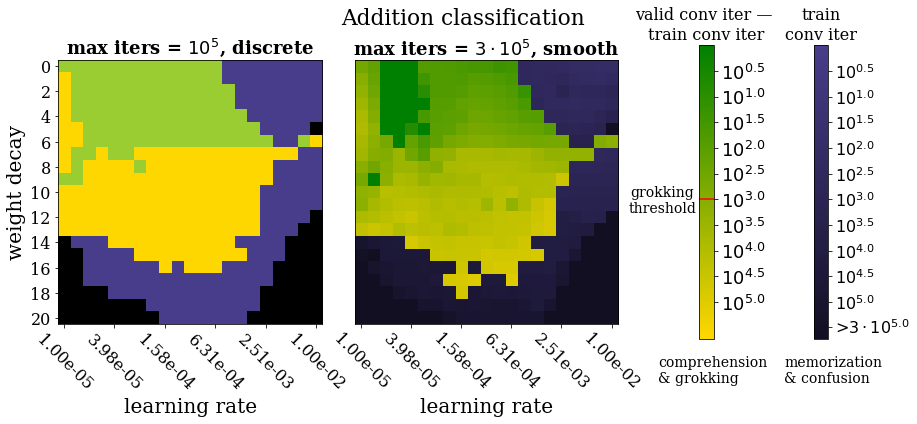

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios':[1, 2.04]})

plot_diagram(axs[0], cls_data['tanh'], legend=False)
plot_smooth_diagram(axs[1], fig, cls_long_data, cls_long_train, cls_long_test,
                    y_label=False, thr_pos=0.47)

axs[0].set_title('max iters = $10^5$, discrete', fontsize=18, fontweight='bold')
axs[1].set_title('max iters = $3 \cdot 10^5$, smooth', fontsize=18, fontweight='bold')

plt.suptitle('Addition classification', y=0.93)
plt.subplots_adjust(wspace=0.08)

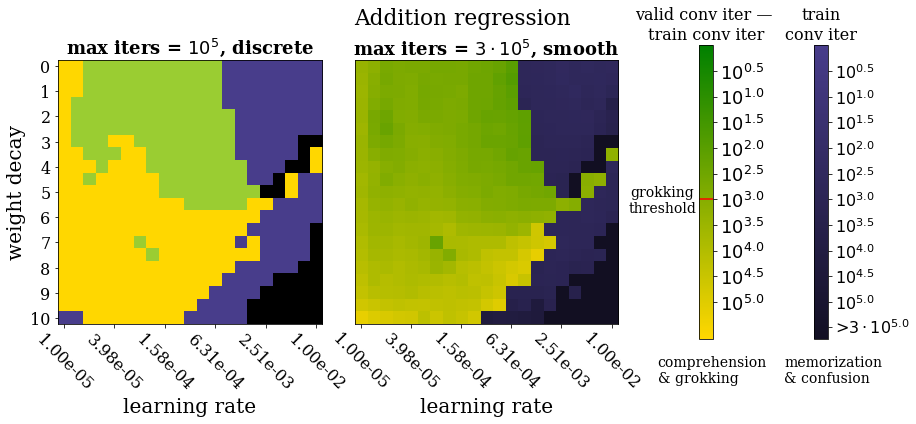

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios':[1, 2.04]})

plot_diagram(axs[0], regr_data['tanh'], legend=False)
plot_smooth_diagram(axs[1], fig, regr_long_data, regr_long_train, regr_long_test,
                    y_label=False, thr_pos=0.47)

axs[0].set_title('max iters = $10^5$, discrete', fontsize=18, fontweight='bold')
axs[1].set_title('max iters = $3 \cdot 10^5$, smooth', fontsize=18, fontweight='bold')

plt.suptitle('Addition regression', y=0.93)
plt.subplots_adjust(wspace=0.08)